# 彩票预测
本项目使用RNN进行彩票预测。

使用人工智能技术来预测彩票，是这次的主题，那么预测哪种彩票呢？我们先选择简单一些的，就是排列组合少一些的，如果证明我们的模型work，再扩展到其他的彩票上。最终我选择了[`排列三`](https://baike.baidu.com/item/排列三/343981?fr=aladdin), 从000-999的数字中选取1个3位数，一共有1000种，中奖概率就是千分之一，够简单了吧。

历史数据在[`这里`](https://datachart.500.com/)。

数据是按照每期一组数的顺序排列的，从第一期到最新的一期，实际上是时间序列的数据。跟回归预测有很大的区别，因为特征上没有特殊的意义，不具备一组特征x映射到label y的条件。但是按照时间序列来训练的话就不一样了，输入x是一期的开奖结果，要学习的y是下一期的开奖结果。

彩票的开奖结果是一个随机分布，跟投骰子、抛硬币差不多，从数学角度看没有规律可言。我的预期是，虽然数学模型是随机的，但是一旦跟现实世界的物体发生关系，总会受到某种影响吧，比如量子纠缠，万有引力，动力学，空气阻力，空气湿度，开奖时刻的机器电压强度，开奖器材的损耗，每个球的质量的差异，吹球设备的物理特性，装球器皿的特定形状等等因素所产生的规律性的东西。

看得出来以上所列出的和没列出的都是增加不确定性、随机性的因素，但是也有可能每次开奖这些相同的特点可能造成某种规律性的结果出来，比如根据这些物理特性的影响，某个球特别容易开出来。一旦是这样，那么就有迹可循，让我们的学习器学到规律。




## LSTM介绍
我们需要从过往的历史数据中寻找规律，[`LSTM`](https://en.wikipedia.org/wiki/Long_short-term_memory)再适合不过了。如果你对LSTM不熟悉的话，以下几篇文章建议你阅读：

[`Understanding LSTM Networks`](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[`[译] 理解 LSTM 网络`](http://www.jianshu.com/p/9dc9f41f0b29)

[`RNN以及LSTM的介绍和公式梳理`](http://blog.csdn.net/Dark_Scope/article/details/47056361)


## 辅助函数
 - `load_data` 加载数据集
 - `preprocess_and_save_data` 数据集预处理，将每期号码转成字典

In [13]:
import tensorflow as tf
import os
import pickle

def load_data(path):
    """
    Load Dataset from File
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data

def preprocess_and_save_data(dataset_path, create_lookup_tables):
    """
    Preprocess Text Data
    """
    text = load_data(dataset_path)
    
    text = text.lower()
    #text = text.split()
    
    words = [word for word in text.split()]

    reverse_words = [text.split()[idx] for idx in (range(len(words)-1, 0, -1))]
    vocab_to_int, int_to_vocab = create_lookup_tables()#text
    #int_text = [vocab_to_int[word] for word in text]
    int_text = [vocab_to_int[word] for word in reverse_words]
    pickle.dump((int_text, vocab_to_int, int_to_vocab), open('preprocess.p', 'wb'))


def load_preprocess():
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    return pickle.load(open('preprocess.p', mode='rb'))

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


In [2]:
tf.__version__

'2.0.0-dev20190210'

## 加载数据集

In [2]:
data_dir = './data/cp.txt'
text = load_data(data_dir)

## 看看数据集的结构
可以修改 `view_sentence_range` 用来查看数据集的不同部分。

In [3]:
view_sentence_range = (0, 10)

import numpy as np

print('数据情况：')
print('不重复单词(彩票开奖记录)的个数: {}'.format(len({word: None for word in text.split()})))
scenes = text.split('\n\n')
sentence_count_scene = [scene.count('\n') for scene in scenes]
print('开奖期数: {}期'.format(int(np.average(sentence_count_scene))))

sentences = [sentence for scene in scenes for sentence in scene.split('\n')]
print('行数: {}'.format(len(sentences)))
word_count_sentence = [len(sentence.split()) for sentence in sentences]
print('平均每行单词数: {}'.format(np.ceil(np.average(word_count_sentence))))

print()
print('开奖记录从 {} 到 {}:'.format(*view_sentence_range))
print('\n'.join(text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

数据情况：
不重复单词(彩票开奖记录)的个数: 988
开奖期数: 4656期
行数: 4657
平均每行单词数: 1.0

开奖记录从 0 到 10:
202
243
580
306
598
900
761
262
891
623


一共4656条记录，4600多期了。共出现了988个不重复的结果，就是说还有（1000 – 988）12组数到现在还没有开出来过。文件中第一行是最新的一期，第二行是之前的一期，。。。，最后一行是第一期。

我们可以把三个数组合成一组数，就像数据集中体现的那样，并且把一组数当作一个数或者说当作一个单词。这样在预处理数据集的时候会简单一些，从索引到单词（0 -> ‘000’）和从单词到索引（‘012’-> 12）其实都是同一个数。

## 预测网络介绍

网络的输入是每一期的开奖结果，总共有1000组数，用one hot编码是一个1000维的稀疏向量：

<img src="assets/v2-09e1bda72c4b903e25db203ab4aa6dc6_hd.jpg">

使用one hot稀疏向量在输入层与网络第一层做矩阵乘法时会很没有效率，因为向量里面大部分都是0， 矩阵乘法浪费了大量的计算，最终矩阵运算得出的结果是向量中值为1的列所对应的矩阵中的行向量。
<img src="assets/lookup_matrix.png">
图片[`来源`](https://github.com/udacity/cn-deep-learning/blob/master/tutorials/embeddings/assets/lookup_matrix.png)

这看起来很像用索引查表一样，one hot向量中值为1的位置作为下标，去索引参数矩阵中的行向量。

为了代替矩阵乘法，我们将参数矩阵当作一个查找表（lookup table）或者叫做嵌入矩阵（embedding matrix），将每组开奖数据所对应的数作为索引，比如“958”，对应索引就是958，然后在查找表中找第958行。
<img src="assets/tokenize_lookup.png">
这其实跟替换之前的模型没有什么不同，嵌入矩阵就是参数矩阵，嵌入层仍然是隐层。查找表只是矩阵乘法的一种便捷方式，它会像参数矩阵一样被训练，是要学习的参数。

下面就是我们要构建的网络架构，从嵌入层输出的向量进入LSTM层进行时间序列的学习，然后经过softmax预测出下一期的开奖结果。
<img src="assets/network_diagram.png">

网络训练的代码，使用了几个trick，在下文<[`构建计算图`](#构建计算图)>和<[`训练`](#训练)>章节会做说明，<[`结论`](#结论)>在最后。

几个图表的位置：

- [`真实值在预测值中的距离图表`](#真实值在预测值中的距离图表)
- [`显示训练Loss`](#显示训练Loss)
- [`显示测试Loss`](#显示测试Loss)
- [`显示准确率`](#显示准确率)
- [`显示预测结果和实际开奖结果`](#显示预测结果和实际开奖结果)
- [`生成往期开奖结果的相似度分布`](#生成往期开奖结果的相似度分布)

## 编码实现

### 实现数据预处理
首先要做的事是对数据进行预处理，要实现下面的函数：
- Lookup Table

### Lookup Table
使用词向量之前，我们需要先准备好单词(彩票开奖记录)和ID之间的转换关系。在这个函数中，创建并返回两个字典：
- 单词到ID的转换字典： `vocab_to_int`
- ID到单词的转换字典： `int_to_vocab`


In [4]:
import numpy as np
from collections import Counter

def create_lookup_tables():
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    vocab_to_int = {str(ii).zfill(3) : ii for ii in range(1000)}
    int_to_vocab = {ii : str(ii).zfill(3) for ii in range(1000)}
    return vocab_to_int, int_to_vocab


### 处理所有数据并保存
将每期结果按照从第一期开始的顺序保存到文件中。

In [6]:
# Preprocess Training, Validation, and Testing Data
preprocess_and_save_data(data_dir, create_lookup_tables)

### Check Point
这是第一个存档点，如果你想读档或者这个notebook重启了的话，你可以从这里开始。预处理的数据已经保存在磁盘上了。

In [14]:
import numpy as np

int_text, vocab_to_int, int_to_vocab = load_preprocess()

## 构建神经网络
要构建RNN，我们来实现如下几个函数：
- get_inputs
- get_init_cell
- get_embed
- build_rnn
- build_nn
- get_batches


### Batches
使用 `int_text` 实现 `get_batches` 函数用来创建输入和目标的批量数据batches。   
每一个batch包含两个元素：
- 第一个元素是形状为 `[batch size, sequence length]` 的输入batch。
- 第二个元素是形状为 `[batch size, sequence length]` 的目标batch。

如果最后的数据不够组成一个batch的话，则抛弃这些数据。

举个栗子, `get_batches([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 2, 3)` 应该返回如下的Numpy数组：
```
[
  # First Batch
  [
    # Batch of Input
    [[ 1  2  3], [ 7  8  9]],
    # Batch of targets
    [[ 2  3  4], [ 8  9 10]]
  ],
 
  # Second Batch
  [
    # Batch of Input
    [[ 4  5  6], [10 11 12]],
    # Batch of targets
    [[ 5  6  7], [11 12 13]]
  ]
]
```

In [15]:
def get_batches(int_text, batch_size, seq_length):
    """
    Return batches of input and target
    :param int_text: Text with the words replaced by their ids
    :param batch_size: The size of batch
    :param seq_length: The length of sequence
    :return: Batches as a Numpy array
    """
    batchCnt = len(int_text) // (batch_size * seq_length)
    int_text_inputs = int_text[:batchCnt * (batch_size * seq_length)]
    int_text_targets = int_text[1:batchCnt * (batch_size * seq_length)+1]

    result_list = []
    x = np.array(int_text_inputs).reshape(1, batch_size, -1)
    y = np.array(int_text_targets).reshape(1, batch_size, -1)

    x_new = np.dsplit(x, batchCnt)
    y_new = np.dsplit(y, batchCnt)

    for ii in range(batchCnt):
        x_list = []
        x_list.append(x_new[ii][0])
        x_list.append(y_new[ii][0])
        result_list.append(x_list)

    return np.array(result_list)


# get_batches([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 2, 3)

## 训练神经网络
### 超参
调整如下参数：

-  `num_epochs` 设置训练几代。
-  `batch_size` 是批次大小。
-  `rnn_size` 是RNN的大小（隐藏节点的维度）。
-  `embed_dim` 是嵌入层的维度。
-  `seq_length` 是序列的长度，始终为1。
-  `learning_rate` 是学习率。
-  `show_every_n_batches` 是过多少batch以后打印训练信息。

In [16]:
vocab_size = len(int_to_vocab)

# Batch Size
batch_size = 32  # 64
# RNN Size
rnn_size = 1000
# Embedding Dimension Size
embed_dim = 256  # 1000
# Sequence Length
seq_length = 1  # 100
# Learning Rate
learning_rate = 0.01
# Show stats for every n number of batches
show_every_n_batches = 10

save_dir = './save'

### 构建计算图
使用实现的神经网络构建计算图。

In [23]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

MODEL_DIR = "./models"

train_batches = get_batches(int_text[:-(batch_size + 1)], batch_size, seq_length)
test_batches = get_batches(int_text[-(batch_size + 1):], batch_size, seq_length)
losses = {'train': [], 'test': []}
accuracies = {'accuracy': [], 'topk': []}


class cp_network(object):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.best_acc = 0

        self.model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embed_dim,
                                      batch_input_shape=[batch_size, None]),
            tf.keras.layers.LSTM(rnn_size,
                                 return_sequences=True,
                                 stateful=True,
                                 recurrent_initializer='glorot_uniform'),
            tf.keras.layers.Dense(vocab_size)
        ])
        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam()
        self.ComputeLoss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.ComputeAccuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.ComputeKAccuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10)

        if tf.io.gfile.exists(MODEL_DIR):
            #             print('Removing existing model dir: {}'.format(MODEL_DIR))
            #             tf.io.gfile.rmtree(MODEL_DIR)
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
        self.test_summary_writer = summary_ops_v2.create_file_writer(test_dir, flush_millis=10000, name='test')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")  # 'ckpt_{epoch}'
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    @tf.function
    def train_step(self, x, y):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            logits = tf.reshape(logits, [batch_size, -1])
            loss = self.ComputeLoss(y, logits)
            self.ComputeAccuracy(y, logits)
            self.ComputeKAccuracy(y, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, epochs=25, log_freq=50):
        for i in range(epochs):
            train_start = time.time()
            with self.train_summary_writer.as_default():
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

                # Datasets can be iterated over like any other Python iterable.
                for batch_i, (x, y) in enumerate(train_batches):
                    loss, logits = self.train_step(x, y)
                    avg_loss(loss)
                    losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        summary_ops_v2.scalar('acc', self.ComputeAccuracy.result(), step=self.optimizer.iterations)
                        summary_ops_v2.scalar('k_acc', self.ComputeKAccuracy.result(), step=self.optimizer.iterations)

                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tLoss: {:0.6f} acc: {:0.6f}  k_acc: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(), loss, (self.ComputeAccuracy.result()),
                            self.ComputeKAccuracy.result(), rate))

                        avg_loss.reset_states()
                        self.ComputeAccuracy.reset_states()
                        self.ComputeKAccuracy.reset_states()

                        start = time.time()

            train_end = time.time()
            print('\nTrain time for epoch #{} ({} total steps): {}'.format(i + 1, self.optimizer.iterations.numpy(),
                                                                           train_end - train_start))

            with self.test_summary_writer.as_default():
                self.testing(self.optimizer.iterations)
            # self.checkpoint.save(self.checkpoint_prefix)
        self.export_path = os.path.join(MODEL_DIR, 'export')

    def testing(self, step_num):
        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

        for batch_i, (x, y) in enumerate(test_batches):
            logits = self.model(x, training=False)
            logits = tf.reshape(logits, [batch_size, -1])
            avg_loss(self.ComputeLoss(y, logits))
            self.ComputeAccuracy(y, logits)
            self.ComputeKAccuracy(y, logits)
            losses['test'].append(avg_loss.result())
            accuracies['accuracy'].append(self.ComputeAccuracy.result())
            accuracies['topk'].append(self.ComputeKAccuracy.result())

        print('Model test set loss: {:0.6f} acc: {:0.6f} k_acc: {:0.6f}'.format(avg_loss.result(),
                                                                                self.ComputeAccuracy.result(),
                                                                                self.ComputeKAccuracy.result()))

        summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        summary_ops_v2.scalar('acc', self.ComputeAccuracy.result(), step=step_num)
        summary_ops_v2.scalar('k_acc', self.ComputeKAccuracy.result(), step=step_num)

        if self.ComputeAccuracy.result() > self.best_acc:
            self.best_acc = self.ComputeAccuracy.result()
            print("best acc = {}".format(self.best_acc))
            self.checkpoint.save(self.checkpoint_prefix)
#             self.model.save_weights(self.checkpoint_prefix.format(epoch=step_num))


## 训练
在预处理过的数据上训练神经网络。 

 - batches：是训练批数据
 - test_batches：是测试批数据
 - losses：保存训练损失和测试损失
 - accuracies：保存各类准确率

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# import seaborn as sns
import matplotlib.pyplot as plt

cp_net=cp_network()
cp_net.training()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           256000    
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (32, None, 1000)          5028000   
_________________________________________________________________
dense (Dense)                (32, None, 1000)          1001000   
Total params: 6,285,000
Trainable params: 6,285,000
Non-trainable params: 0
_________________________________________________________________
Step #50	Loss: 6.900598 acc: 0.000625  k_acc: 0.009375 (7.284058598626473 steps/sec)
Step #100	Loss: 6.902828 acc: 0.001250  k_acc: 0.008125 (12.56948301573565 steps/sec)

Train time for epoch #1 (144 total steps): 14.467729091644287
Model test set loss: 6.916893 acc: 0.000694 k_acc: 0.009722
best acc = 0.0006944444612599909
Step #150	Loss: 6.723903 acc: 0.000613  k_acc: 0.

## 显示训练Loss

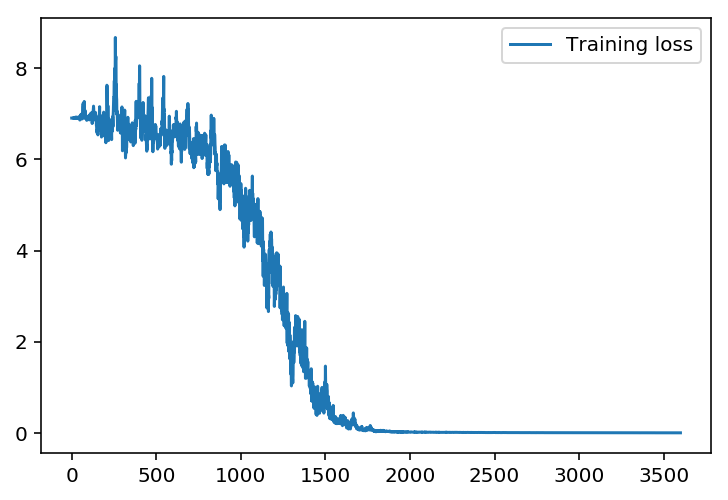

In [11]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 显示测试Loss
测试损失始终没有降下去。。。

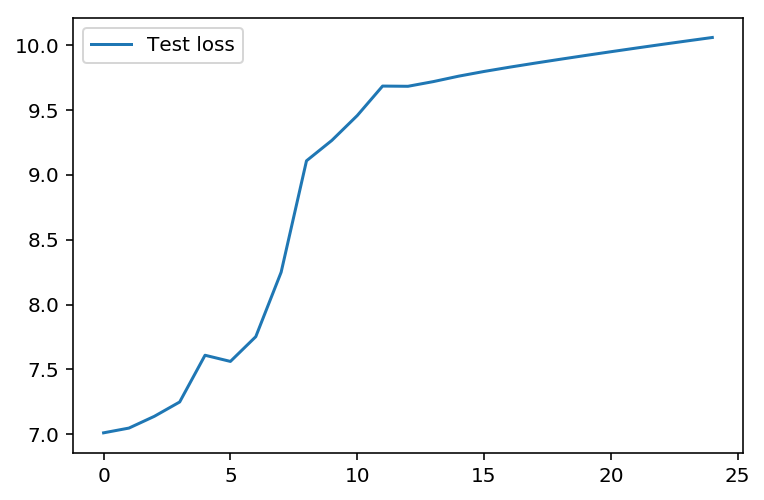

In [12]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 显示准确率
 - 测试准确率
 - Top K准确率

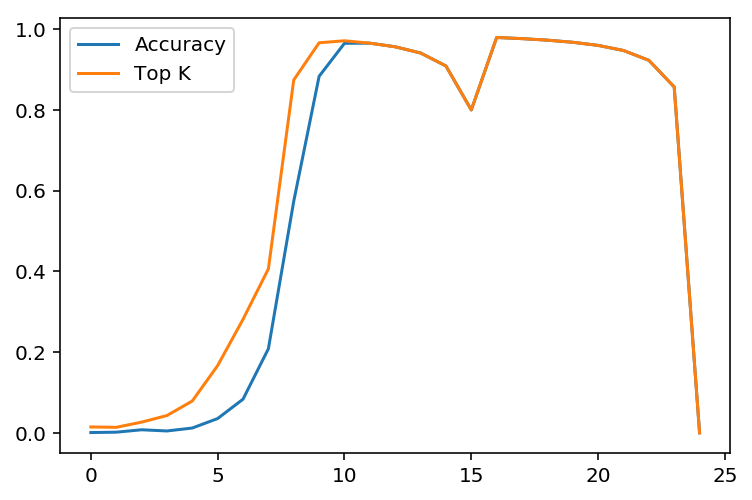

In [13]:
plt.plot(accuracies['accuracy'], label='Accuracy')
plt.plot(accuracies['topk'], label='Top K')
plt.legend()
_ = plt.ylim()

## 显示预测结果和实际开奖结果
感觉从趋势上看起来还行


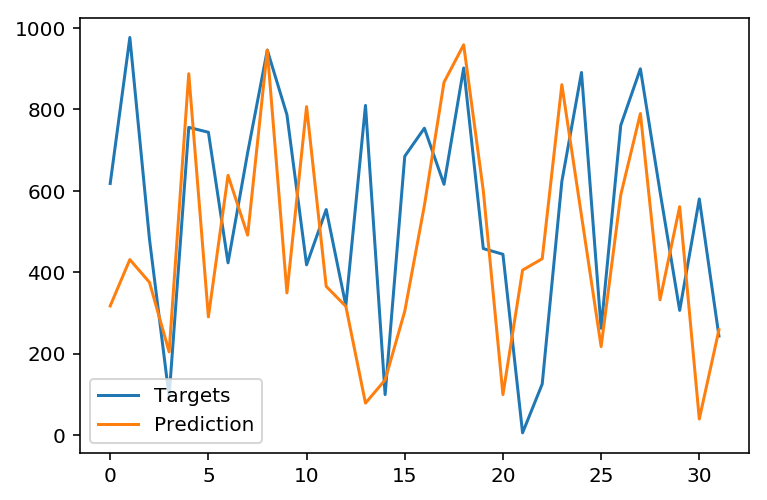

In [14]:
for batch_i, (x, y) in enumerate(test_batches):
    plt.plot(y, label='Targets')
    plt.plot(np.squeeze(cp_net.model(x).numpy().argmax(2)), label='Prediction')
    plt.legend()
    _ = plt.ylim()

## 生成往期开奖结果的相似度分布

In [15]:
# embed_mat = restore_cp.model.layers[0]
layer_model = tf.keras.models.Model(inputs=cp_net.model.input, outputs=cp_net.model.layers[0].output)

embed_mat=[]
for i in range(1000):
    embed_mat.append(layer_model(i).numpy())
embed_mat=np.array(embed_mat)

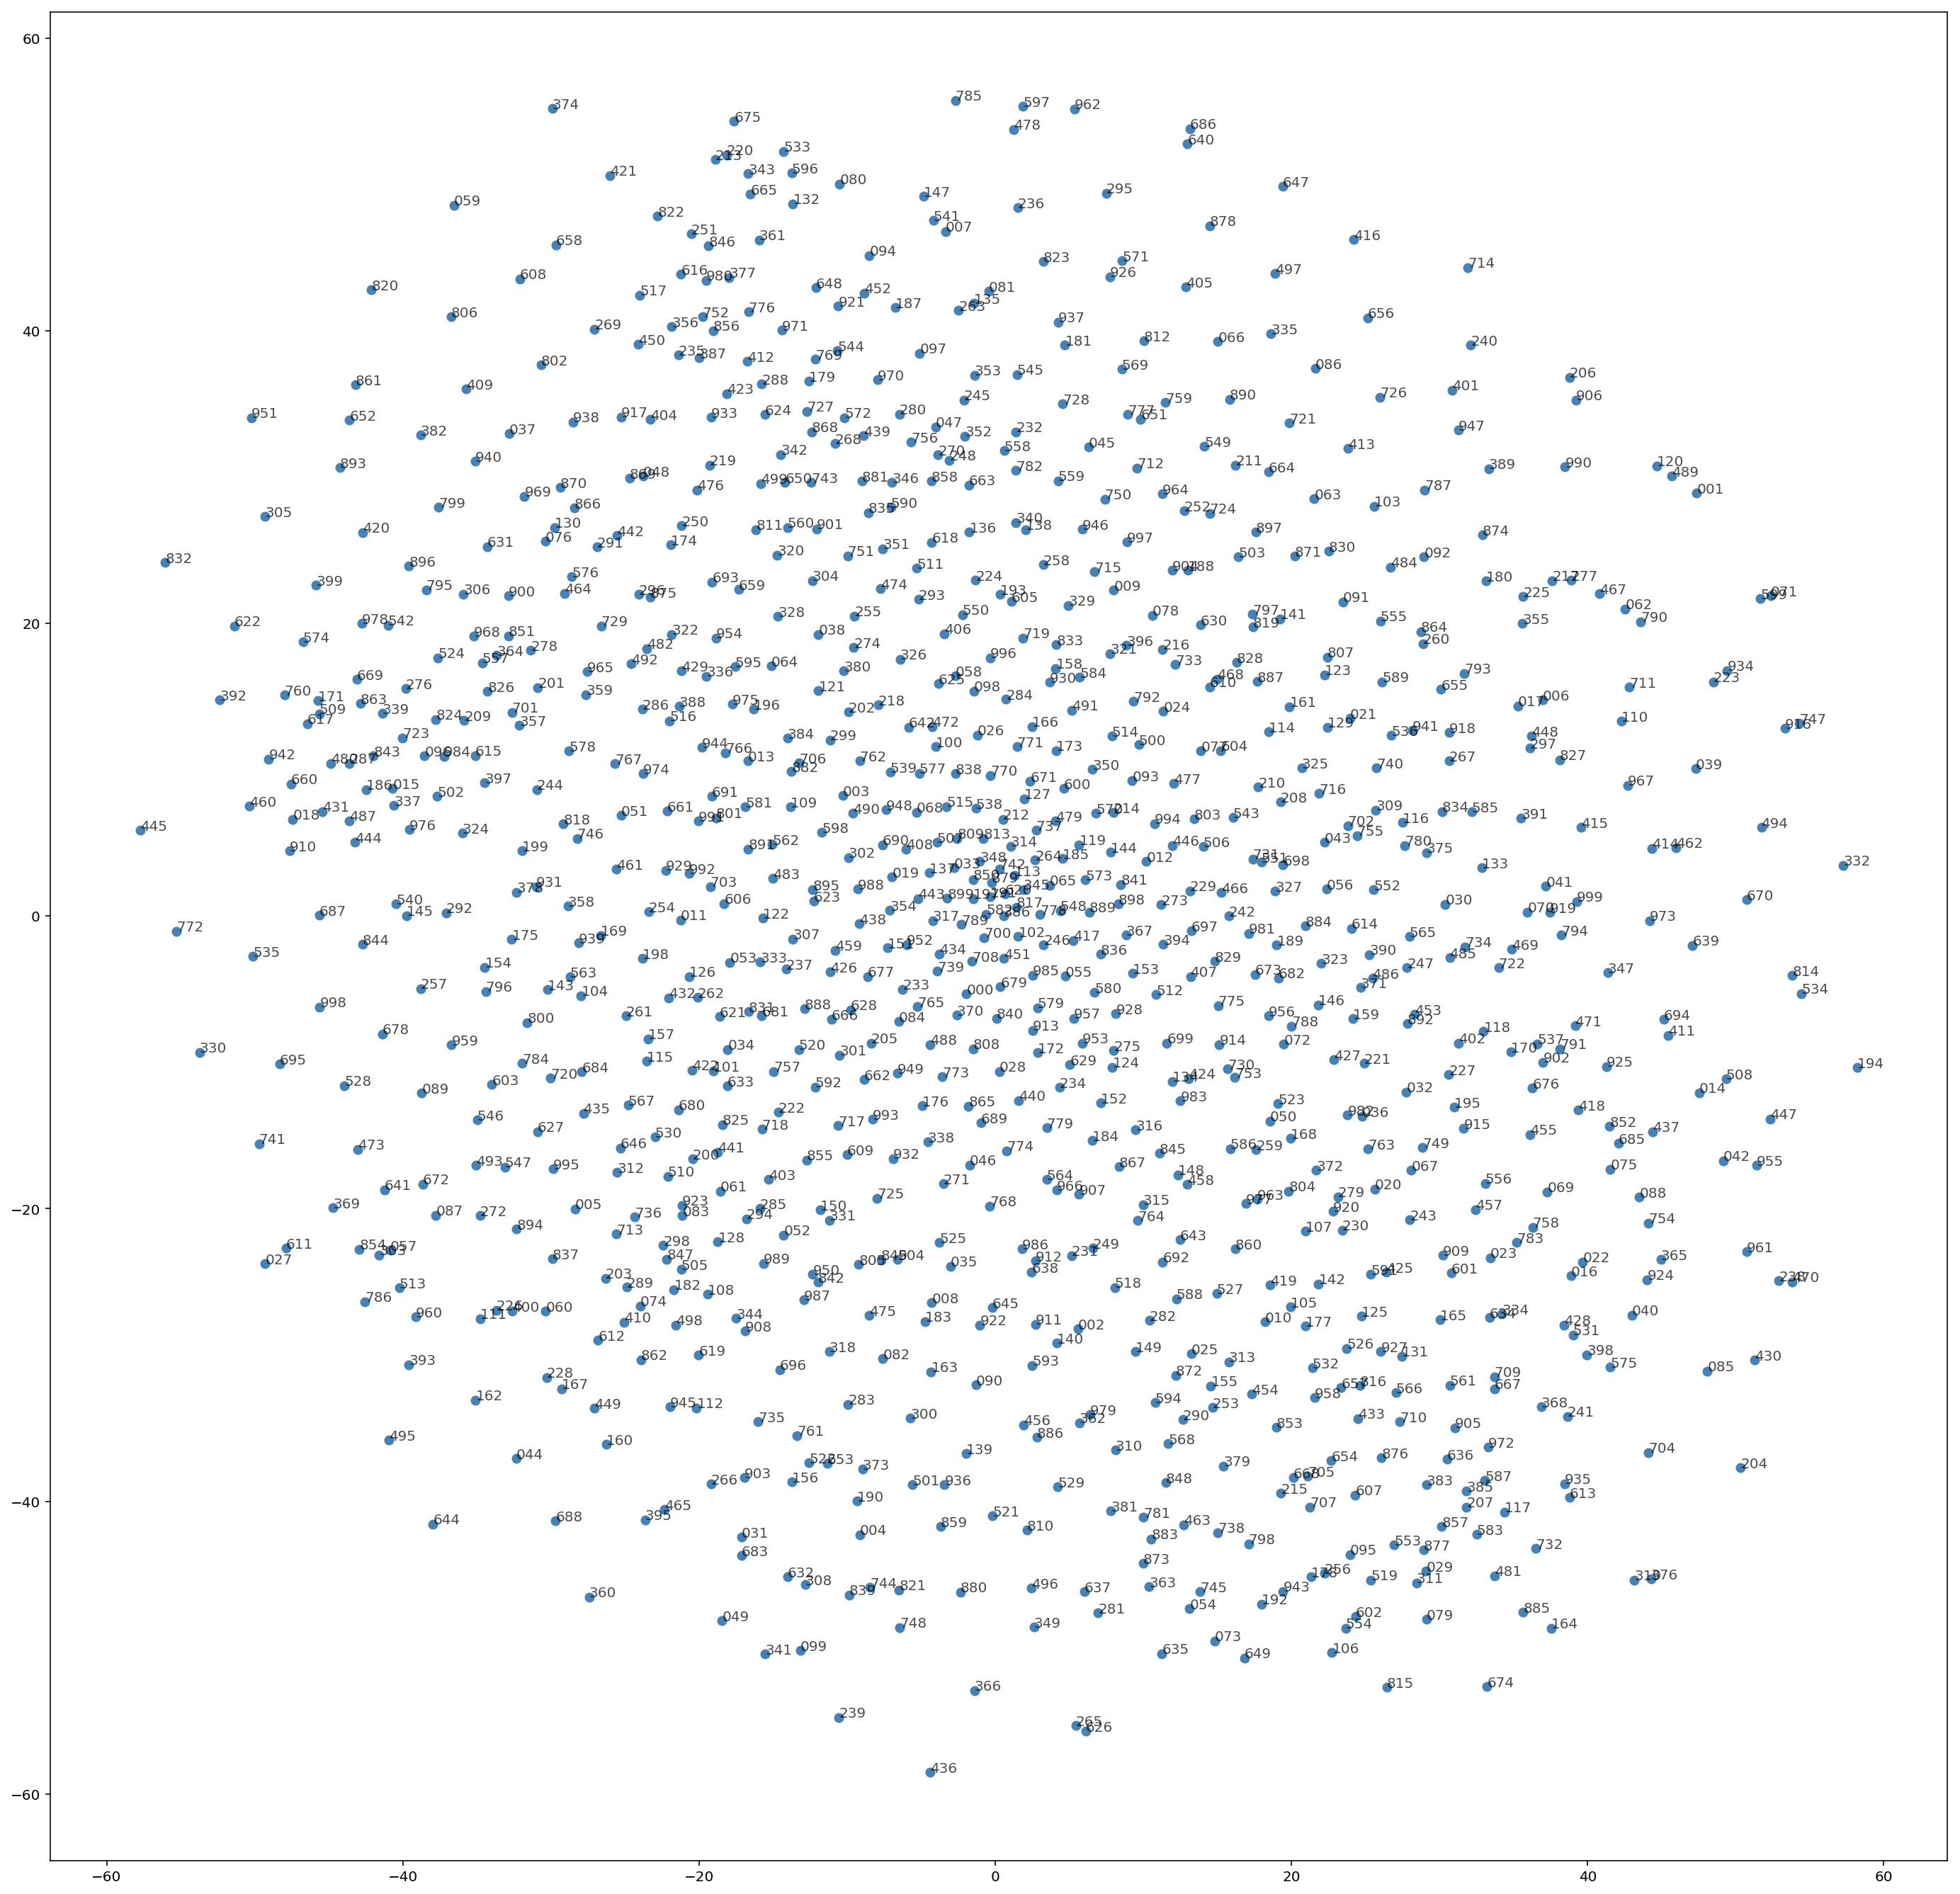

In [17]:
from sklearn.manifold import TSNE

viz_words = 1000
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(24, 24))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

在训练不够充分的情况下，从往期开奖的相互之间的距离图可以看出，大部分的数据点相互之间的距离基本上都差不多，完全符合彩票随机的特性，出现任何一种结果的概率都是一样的。甚至上一期和下一期之间的距离也有可能间隔非常远，只有一部分数据点之间联系的比较紧密，这部分数据点我们还可以试试运气。

## 实现生成预测函数

In [11]:
restore_cp=cp_network(1)
# restore_cp.model.load_weights(tf.train.latest_checkpoint(restore_cp.checkpoint_dir))
restore_cp.model.build(tf.TensorShape([1, None]))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            256000    
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (1, None, 1000)           5028000   
_________________________________________________________________
dense_1 (Dense)              (1, None, 1000)           1001000   
Total params: 6,285,000
Trainable params: 6,285,000
Non-trainable params: 0
_________________________________________________________________


## 生成彩票号码
开始进行预测彩票了，并打印出topk的预测。
 - `gen_length` 作为你想生成多少期的号码。
 - `prime_word` 是前一期号码
 

In [34]:
gen_length = 17
prime_word = ["623", "891", "262", "761", "900", "598", "306", "580", "243", "202"]
gen_sentences = []
temperature = 1.0

dyn_input = [[vocab_to_int[word] for word in prime_word]]

val_data = [[103],[883],[939],[36],[435],[173],[572],[828],[509],[723],[145],[621],[535],[385],[98],[321],[427]]

restore_cp.model.reset_states()
for n in range(gen_length):
    predictions = restore_cp.model(np.array(dyn_input))
        
    pred_topk=tf.nn.top_k(predictions[-1], 10)
    for i, (label_id, pred_indicies, pred_values) in enumerate(zip(val_data[n], pred_topk.indices, pred_topk.values)):
        print("label is {} top10 [{}] probabilities [{}]".format(label_id, pred_indicies, 
                                                                       [np.round(val.numpy(),2) for val in pred_values]))
    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)

    # using a multinomial distribution to predict the word returned by the model
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
#     predicted_id=predictions.numpy().argmax()

    # We pass the predicted word as the next input to the model
    # along with the previous hidden state
    dyn_input = tf.expand_dims([predicted_id], 0)

    gen_sentences.append(int_to_vocab[predicted_id])

cp_script = ' '.join(gen_sentences)
cp_script = cp_script.replace('\n ', '\n')
cp_script = cp_script.replace('( ', '(')
        
print("预测是：", cp_script)

label is 103 top10 [[890 539 353 188 633 727 259 638 106 154]] probabilities [[4.73, 4.42, 3.89, 3.62, 3.6, 3.48, 3.38, 3.38, 3.03, 3.0]]
label is 883 top10 [[760 458 913 186 535 739 753 725 623 598]] probabilities [[11.72, 9.91, 9.83, 9.73, 9.65, 9.59, 9.37, 9.24, 9.2, 9.07]]
label is 939 top10 [[983 804 642 671  71 917 663  85 824 614]] probabilities [[3.71, 3.69, 3.69, 3.66, 3.42, 3.11, 3.06, 2.91, 2.9, 2.88]]
label is 36 top10 [[526 799 184 782  21 685  63  83 609 467]] probabilities [[7.24, 7.2, 6.57, 6.56, 6.51, 6.44, 5.87, 5.65, 5.58, 5.42]]
label is 435 top10 [[ 63 881 438 784 656 616 634 547 489 502]] probabilities [[6.94, 6.64, 6.13, 6.12, 5.66, 5.3, 5.19, 4.98, 4.89, 4.87]]
label is 173 top10 [[687 895 133 708 608 571 784 376 222 838]] probabilities [[6.1, 5.63, 5.63, 5.05, 4.78, 4.67, 4.62, 4.56, 4.45, 4.45]]
label is 572 top10 [[633 991 756 312 302 638 797 595 372 494]] probabilities [[8.47, 7.36, 7.32, 7.13, 6.64, 6.63, 6.21, 5.92, 5.9, 5.87]]
label is 828 top10 [[282  18

# 结论

先从数据上说，测试集上最好准确率的信息打印如下：

Model test set loss: 9.828722 acc: 0.979592 k_acc: 0.979592

best acc = 0.9795918464660645

正常的开奖概率是1‰。

准确率是97%，比TensorFlow 1.x训练的要好，可能跟网络结构的改变有关。

但实际上根据上面topk的预测，仍然一个都没有猜中。


## 新的思路
既然不能准确的预测，唯一能给我们提供思路的就是学习器学到的趋势，来看看下面的代码。

- int_sentences：里面保存着上面生成的若干期号码
- val_data：是最新几期的开奖号码，作为validate数据集

In [35]:
int_sentences = [int(words) for words in gen_sentences]
int_sentences = int_sentences[1:]

val_data = [[103],[883],[939],[36],[435],[173],[572],[828],[509],[723],[145],[621],[535],[385],[98],[321],[427]]

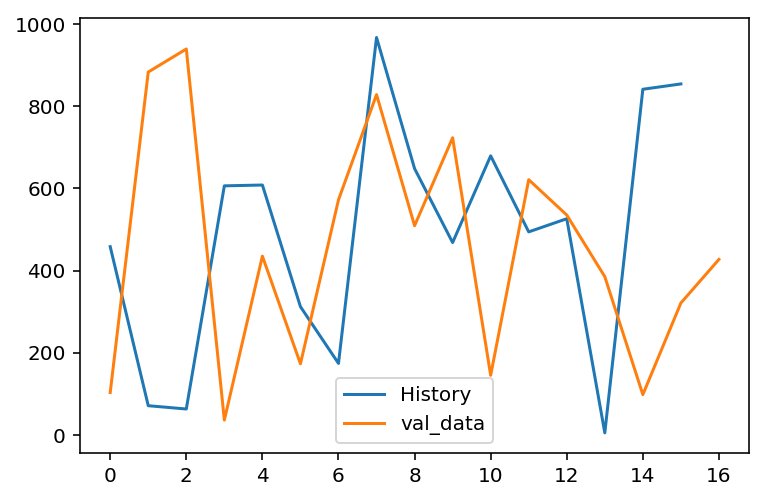

In [36]:
plt.plot(int_sentences, label='History')
plt.plot(val_data, label='val_data')
plt.legend()
_ = plt.ylim()

看起来预测的效果不好，跟随机瞎猜差不多，哈哈哈，剩下的就要靠运气了：）

今天的分享就到这里，大家洗洗睡吧 ：）